In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import statistics
import math

# Section 4.4.2 DPA on RSA

In [3]:
#for Montgomery's method for modular multiplication
r = 2048
n = 1189 #RSA modulus
bit_length = 10

In [4]:
##signal
#0 - 0th nibble
#1 - lower byte
#2 - upper byte (we know there are at most two bytes because n has bit length 11)
#3 - the exact value
def getar(a, signal):
    ar = (a*r)%n
    if signal == 3:
        return ar
    ar_bin = format(ar,'b').zfill(bit_length)
    
    ##if signal = 0th nibble
    if signal == 0:
        ##get the 0th nibble
        temp = ar_bin[6:]
        nibble = int(temp,2)
        return nibble

    ar_bin_array = [int(ar_bin[i]) for i in range(bit_length)]
    ####--convret ar to bytes
    tmp = ar.to_bytes(2,'big')
    lower_byte = tmp[1]
    upper_byte = tmp[0]
    
    if signal == 1:
        return lower_byte
    
    return upper_byte

In [8]:
#save data to file for tikz plot
def savetofile(filename,array, start):
    f = open(filename+".txt", "w")
    f.write("x y\n")
    i = 0
    for i in range(start,len(array)):
        f.write(str(i-start)+" "+str(array[i])+"\n")
        i+=1
    f.close()

In [5]:
##load data
file_no = 10000
q = 10000 #number of time samples

traces = []

for i in range(file_no):
    with open('DPA_Mon/trace_'+str(i)+'.npy', 'rb') as f:
            one_trace = np.load(f, allow_pickle = True)
            traces.append(one_trace)

with open('DPA_Mon/inputs.txt') as f:
    inputs = f.read().splitlines()
    
trace_array = np.array(traces)
trace_array = trace_array.astype(float)

inputs_array = np.array(inputs)
for j in range(file_no): #for each input
        inputs_array[j] = int(inputs_array[j],16)#convert the input values to integers

In [6]:
##save one trace for plot
savetofile("one_trace_mon", trace_array[0], 0)

In [8]:
##print some inputs
print(inputs_array[0])
print(inputs_array[1])
print(inputs_array[2])

900
1083
881


In [9]:
#compute Hamming weight of an integer a
def HW_fun(a):
    abin = format(a,'b').zfill(bit_length)#binary representation of v
    abin_array = [int(abin[i]) for i in range(bit_length)]
    hw = 0
    for i in range(bit_length):
        if abin_array[i] == 1:
            hw = hw+1
    return hw

In [19]:
##signal
#0 - 0th nibble
#1 - lower byte
#2 - upper byte
##----leakage_model - more about the signal
#-----0 identity/exact value
#----1 hamming weight
def compute_corr_coeff(signal, leakage_model, no_of_traces, filename):
    a = []
    for j in range(no_of_traces): #for each input
        tmp = int(inputs_array[j])
        a.append(getar(tmp,signal))
        if leakage_model == 1:
            a[j] = HW_fun(a[j])
            if signal == 1 and j<10:
                print("the "+ str(j) + "th input is " + str(tmp) + ", the modeled leakage for the input is " + str(a[j]))
    
    ind = [i for i in range(no_of_traces)]
    traces = trace_array[ind]

    #store correlation coefficients for each time sample
    corr_coeff = [0 for x in range(q)]
    x = []
    for t in range(q):
        #compute coefficient between the leakages at time sample t and the hypotheses
        corr_coeff[t] = np.corrcoef(traces[:,t],a)[0][1]
#         corr_coeff[t] = abs(corr_coeff[t])
        #for plotting
        x.append(t)
    plt.plot(trace_array[0])    
    plt.plot(x,corr_coeff)
#     plt.xlim(0,q)
    plt.show()
    savetofile(filename,corr_coeff,0)
    return corr_coeff

In [17]:
#with nibble
nibble_corr = compute_corr_coeff(0,0,file_no,"corr_nibble");
nibble_corr_hw = compute_corr_coeff(0,1,file_no, "corr_nibble_hw");

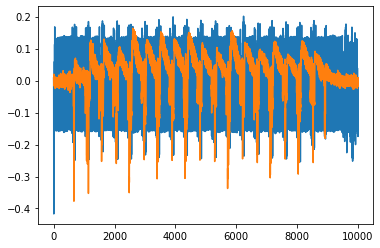

the0th input is 900, the modeled leakage for the input is 6
the1th input is 1083, the modeled leakage for the input is 6
the2th input is 881, the modeled leakage for the input is 6
the3th input is 852, the modeled leakage for the input is 5
the4th input is 1038, the modeled leakage for the input is 4
the5th input is 349, the modeled leakage for the input is 4
the6th input is 911, the modeled leakage for the input is 6
the7th input is 826, the modeled leakage for the input is 5
the8th input is 682, the modeled leakage for the input is 3
the9th input is 861, the modeled leakage for the input is 3


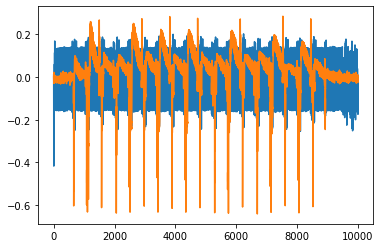

In [20]:
#with lower_byte
lbyte_corr = compute_corr_coeff(1,0,file_no,"corr_lbyte");
lbyte_corr_hw = compute_corr_coeff(1,1,file_no,"corr_lbyte_hw");

In [ ]:
#with upper byte
ubyte_corr = compute_corr_coeff(2,0,file_no,"corr_ubyte");
ubyte_corr_hw = compute_corr_coeff(2,1,file_no,"corr_ubyte_hw");

In [ ]:
#with exact value
exact_corr = compute_corr_coeff(2,0,file_no,"corr_exact");
exact_corr_hw = compute_corr_coeff(2,1,file_no, "corr_exact_hw");

## Section 4.5.1.2 Square and multiply always

In [6]:
##load data
file_no_counter = 10000
q_counter = 15000 #number of time samples

traces_counter = []

for i in range(file_no_counter):
    with open('DPA_Counter/trace_'+str(i)+'.npy', 'rb') as f:
            one_trace = np.load(f, allow_pickle = True)
            traces_counter.append(one_trace)

with open('DPA_Counter/inputs.txt') as f:
    inputs_counter = f.read().splitlines()
    
trace_array_counter = np.array(traces_counter)
trace_array_counter = trace_array_counter.astype(float)

inputs_counter = np.array(inputs_counter)
for j in range(file_no_counter): #for each input
        inputs_counter[j] = int(inputs_counter[j],16)#convert the input values to integers

In [10]:
##save one trace for plot
savetofile("one_trace_counter", trace_array_counter[0], 0)

In [48]:
#0 identity
#1 hamming weight
def compute_corr_coefficient(signal, leakage_model, no_of_traces, filename):
    a = []
    for j in range(no_of_traces): #for each input
        tmp = int(inputs_counter[j])
        a.append(getar(tmp,signal))
        if leakage_model == 1:
            a[j] = HW_fun(a[j])
    
    ind = [i for i in range(no_of_traces)]
    traces = trace_array_counter[ind]

    #store correlation coefficients for each time sample
    corr_coeff = [0 for x in range(q_counter)]
    x = []
    for t in range(q_counter):
        #compute coefficient between the leakages at time sample t and the hypotheses
        corr_coeff[t] = np.corrcoef(traces[:,t],a)[0][1]
#         corr_coeff[t] = abs(corr_coeff[t])
        #for plotting
        x.append(t)
    plt.plot(trace_array_counter[0])    
    plt.plot(x,corr_coeff)
#     plt.xlim(1400,q_counter)
    plt.show()
    savetofile(filename,corr_coeff, 0)
    return corr_coeff

In [ ]:
#nibble
corr_protected_nibble = compute_corr_coefficient(0, 0, file_no_counter, "corr_protected_nibble")
corr_protected_hw_nibble = compute_corr_coefficient(0, 1, file_no_counter, "corr_protected_hw_nibble")

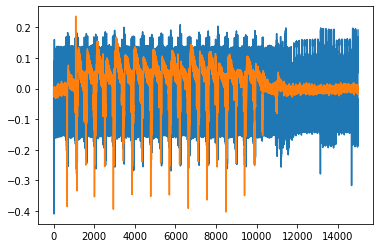

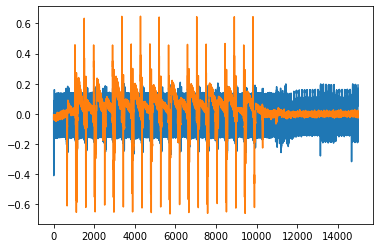

In [51]:
#lower_byte
corr_protected_lbyte = compute_corr_coefficient(1, 0, file_no_counter, "corr_protected_lbyte")
corr_protected_lbyte = compute_corr_coefficient(1, 1, file_no_counter, "corr_protected_hw_lbyte")

In [ ]:
#upper_byte
corr_protected_ubyte = compute_corr_coefficient(2, 0, file_no_counter, "corr_protected_ubyte")
corr_protected_ubyte = compute_corr_coefficient(2, 1, file_no_counter, "corr_protected_hw_ubyte")

In [ ]:
#exact value
corr_protected_exact = compute_corr_coefficient(3, 0, file_no_counter, "corr_protected_exact")
corr_protected_exact = compute_corr_coefficient(3, 1, file_no_counter, "corr_protected_hw_exact")